# Introduction

This is the processing for the ATAC data of the AMO experiment.

# Setup

In [1]:
import scanpy as sc
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

import warnings
import itertools as it
import json
import pickle as pkl

import pybedtools

from nero import Harmonia
from nero import Nero as nr

In [2]:
sc.settings.verbosity = 4
sc.settings.set_figure_params(dpi=80)
sc.settings.n_jobs=16

In [3]:
mountpoint = '/data/clue/'
prefix_atac = mountpoint + 'amo/atac/'

## Load in the Data

In [ ]:
aggr = sc.read_10x_h5(prefix_atac + 'cr/aggr/outs/filtered_peak_bc_matrix.h5', gex_only=False)

## Load in Colors

In [36]:
with open(mountpoint + 'cond_colors.pkl', 'rb') as file:
    cond_colors = pkl.load(file)['hex']

# Processing

In [ ]:
data = dict()
pools = range(5)

In [ ]:
prefix_freemux = prefix_atac + 'demux/freemux/by_well/'
for pool in pools:
    data[pool] = dict()
    data[pool]['adata_raw'] = aggr[[i for i in aggr.obs_names if int(i[-1]) == pool + 1]].copy()
    
    data[pool]['freemux'] = Harmonia.MuxOut(prefix_freemux + 'freemux_well%d.clust1.samples' % (pool + 1))

In [ ]:
deconvolution = pd.DataFrame(index=pools, columns=[str(i) for i in pools])

In [ ]:
for pool in deconvolution.index:
    for c in deconvolution.columns:
        deconvolution.loc[pool, c] = sum(data[pool]['freemux'].sng()['BEST.GUESS'] == c)

In [ ]:
deconvolution = deconvolution.astype(np.int)

In [ ]:
deconvolution

In [ ]:
deconvolution.to_csv(prefix_atac + 'vals/deconvolution_atac.csv')

In [ ]:
plt.figure(figsize=(5,4.4))
sns.heatmap(deconvolution[['0', '1', '3', '4', '2']], vmin=0, vmax=3000);
plt.ylabel('Well')
plt.xlabel('Anonymous Donor');

Now to attach covariates to the donors and then stimulation conditions.

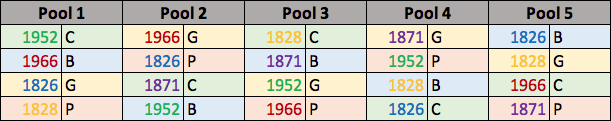

In [ ]:
donor_map = ['71', '28', '52', '26', '66']

In [ ]:
condition_map = {0: ['0', 'P', 'C', 'G', 'B'],
                 1: ['C', '0', 'B', 'P', 'G'], 
                 2: ['B', 'C', 'G', '0', 'P'], 
                 3: ['G', 'B', 'P', 'C', '0'], 
                 4: ['P', 'G', '0', 'B', 'C']}

In [ ]:
for pool in pools:
    data[pool]['covar_df'] = pd.DataFrame(index=[str(i) for i in range(5)], columns=['ind', 'cond'])
    data[pool]['covar_df']['ind'] = donor_map
    data[pool]['covar_df']['cond'] = condition_map[pool]
    
    data[pool]['adata_raw'] = Harmonia.ann_merge(data[pool]['adata_raw'], data[pool]['freemux'].sng(), covars=data[pool]['covar_df'])

In [ ]:
concat = data[0]['adata_raw'].concatenate(*[data[pool]['adata_raw'] for pool in range(1,5)])

In [ ]:
concat.shape

In [5]:
# concat.write_h5ad(prefix_atac + 'h5ads/concat_1.h5ad')
concat = sc.read_h5ad(prefix_atac + 'h5ads/concat_1.h5ad')

In [103]:
# with open(prefix_atac + 'vals/concat_1_bcs.txt', 'w') as file:
#     for bc in concat.obs_names:
#         file.write(bc[:-2] + '\n')

At this point, I import `concat_1.h5ad` into the archR pipeline (`<archR_notebook.ipynb>`) and run latent semantic indexing (LSI).

## Import LSI data

This next cell can take up to 10 minutes.

In [22]:
# genescoremtx = mmread(prefix_atac + 'archR/aggr_genescore/matrix.mtx')
# genescoremtx_csr = csr_matrix(genescoremtx)

# with open(prefix_atac + 'archR/aggr_genescore/barcodes.tsv', 'r') as file:
#     bcs = [i.strip().strip('clue.aggr#') for i in file.readlines()]

# with open(prefix_atac + 'archR/aggr_genescore/genes.tsv', 'r') as file:
#     genes = [i.strip() for i in file.readlines()]

# concat_raw = sc.AnnData(X=genescoremtx_csr.T, var=pd.DataFrame(index=genes), obs=pd.DataFrame(index=bcs))

In [10]:
# concat_raw.write_h5ad(prefix_atac + 'h5ads/concat_raw.h5ad')
concat_raw = sc.read_h5ad(prefix_atac + 'h5ads/concat_raw.h5ad')

In [11]:
concat_raw.shape

(38676, 24919)

In [12]:
LSI_loadings = pd.read_csv(prefix_atac + 'archR/vals/lsi.csv', header=0, index_col=0)
LSI_loadings.index = [i.strip("clue.aggr#") for i in LSI_loadings.index]

In [13]:
LSI_loadings.values.shape

(38676, 30)

In [40]:
concat_raw.obsm['X_pca'] = LSI_loadings.values

In [43]:
sc.pp.neighbors(concat_raw, n_neighbors=40, n_pcs=30)

computing neighbors
    computing neighbors
    using 'X_pca' with n_pcs = 30
    computed neighbors (0:00:33)
    computed connectivities (0:00:07)
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:40)


In [44]:
sc.tl.umap(concat_raw)

computing UMAP
	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:01:04)


In [45]:
sc.tl.leiden(concat_raw)

running Leiden clustering
    finished: found 25 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:24)


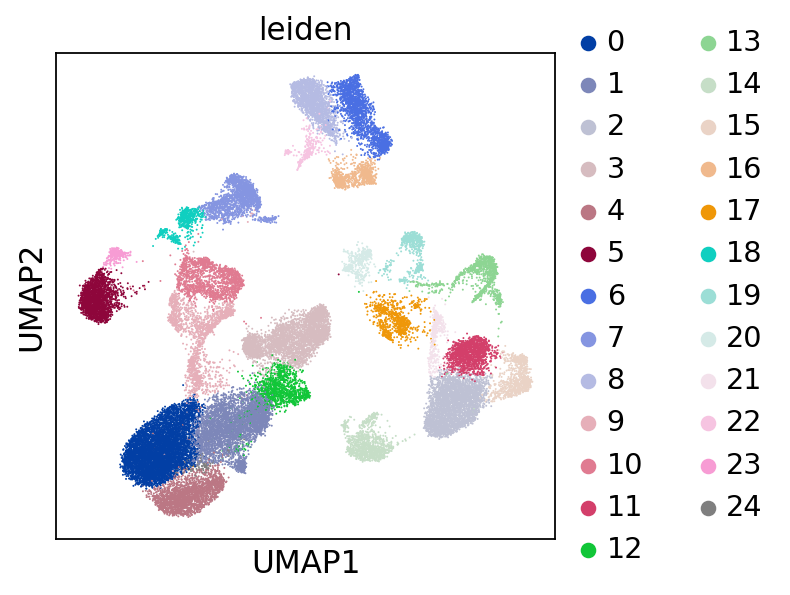

In [60]:
sc.pl.umap(concat_raw, color='leiden');

Looks great. Now to export so I can subcluster using `subcluster.ipynb`.

In [59]:
# concat_raw.write_h5ad(prefix_atac + 'h5ads/concat_2.h5ad')

Run `subcluster.ipynb`...

In [68]:
concat_raw = sc.read_h5ad(prefix_atac + 'h5ads/concat_3.h5ad')

## Merge `.obs`

In [69]:
obs_to_join = concat.obs.copy()

In [70]:
obs_to_join.index = [i[:-2] for i in obs_to_join.index]

In [71]:
concat_raw.obs = concat_raw.obs.join(obs_to_join)

# Analyze Clusters

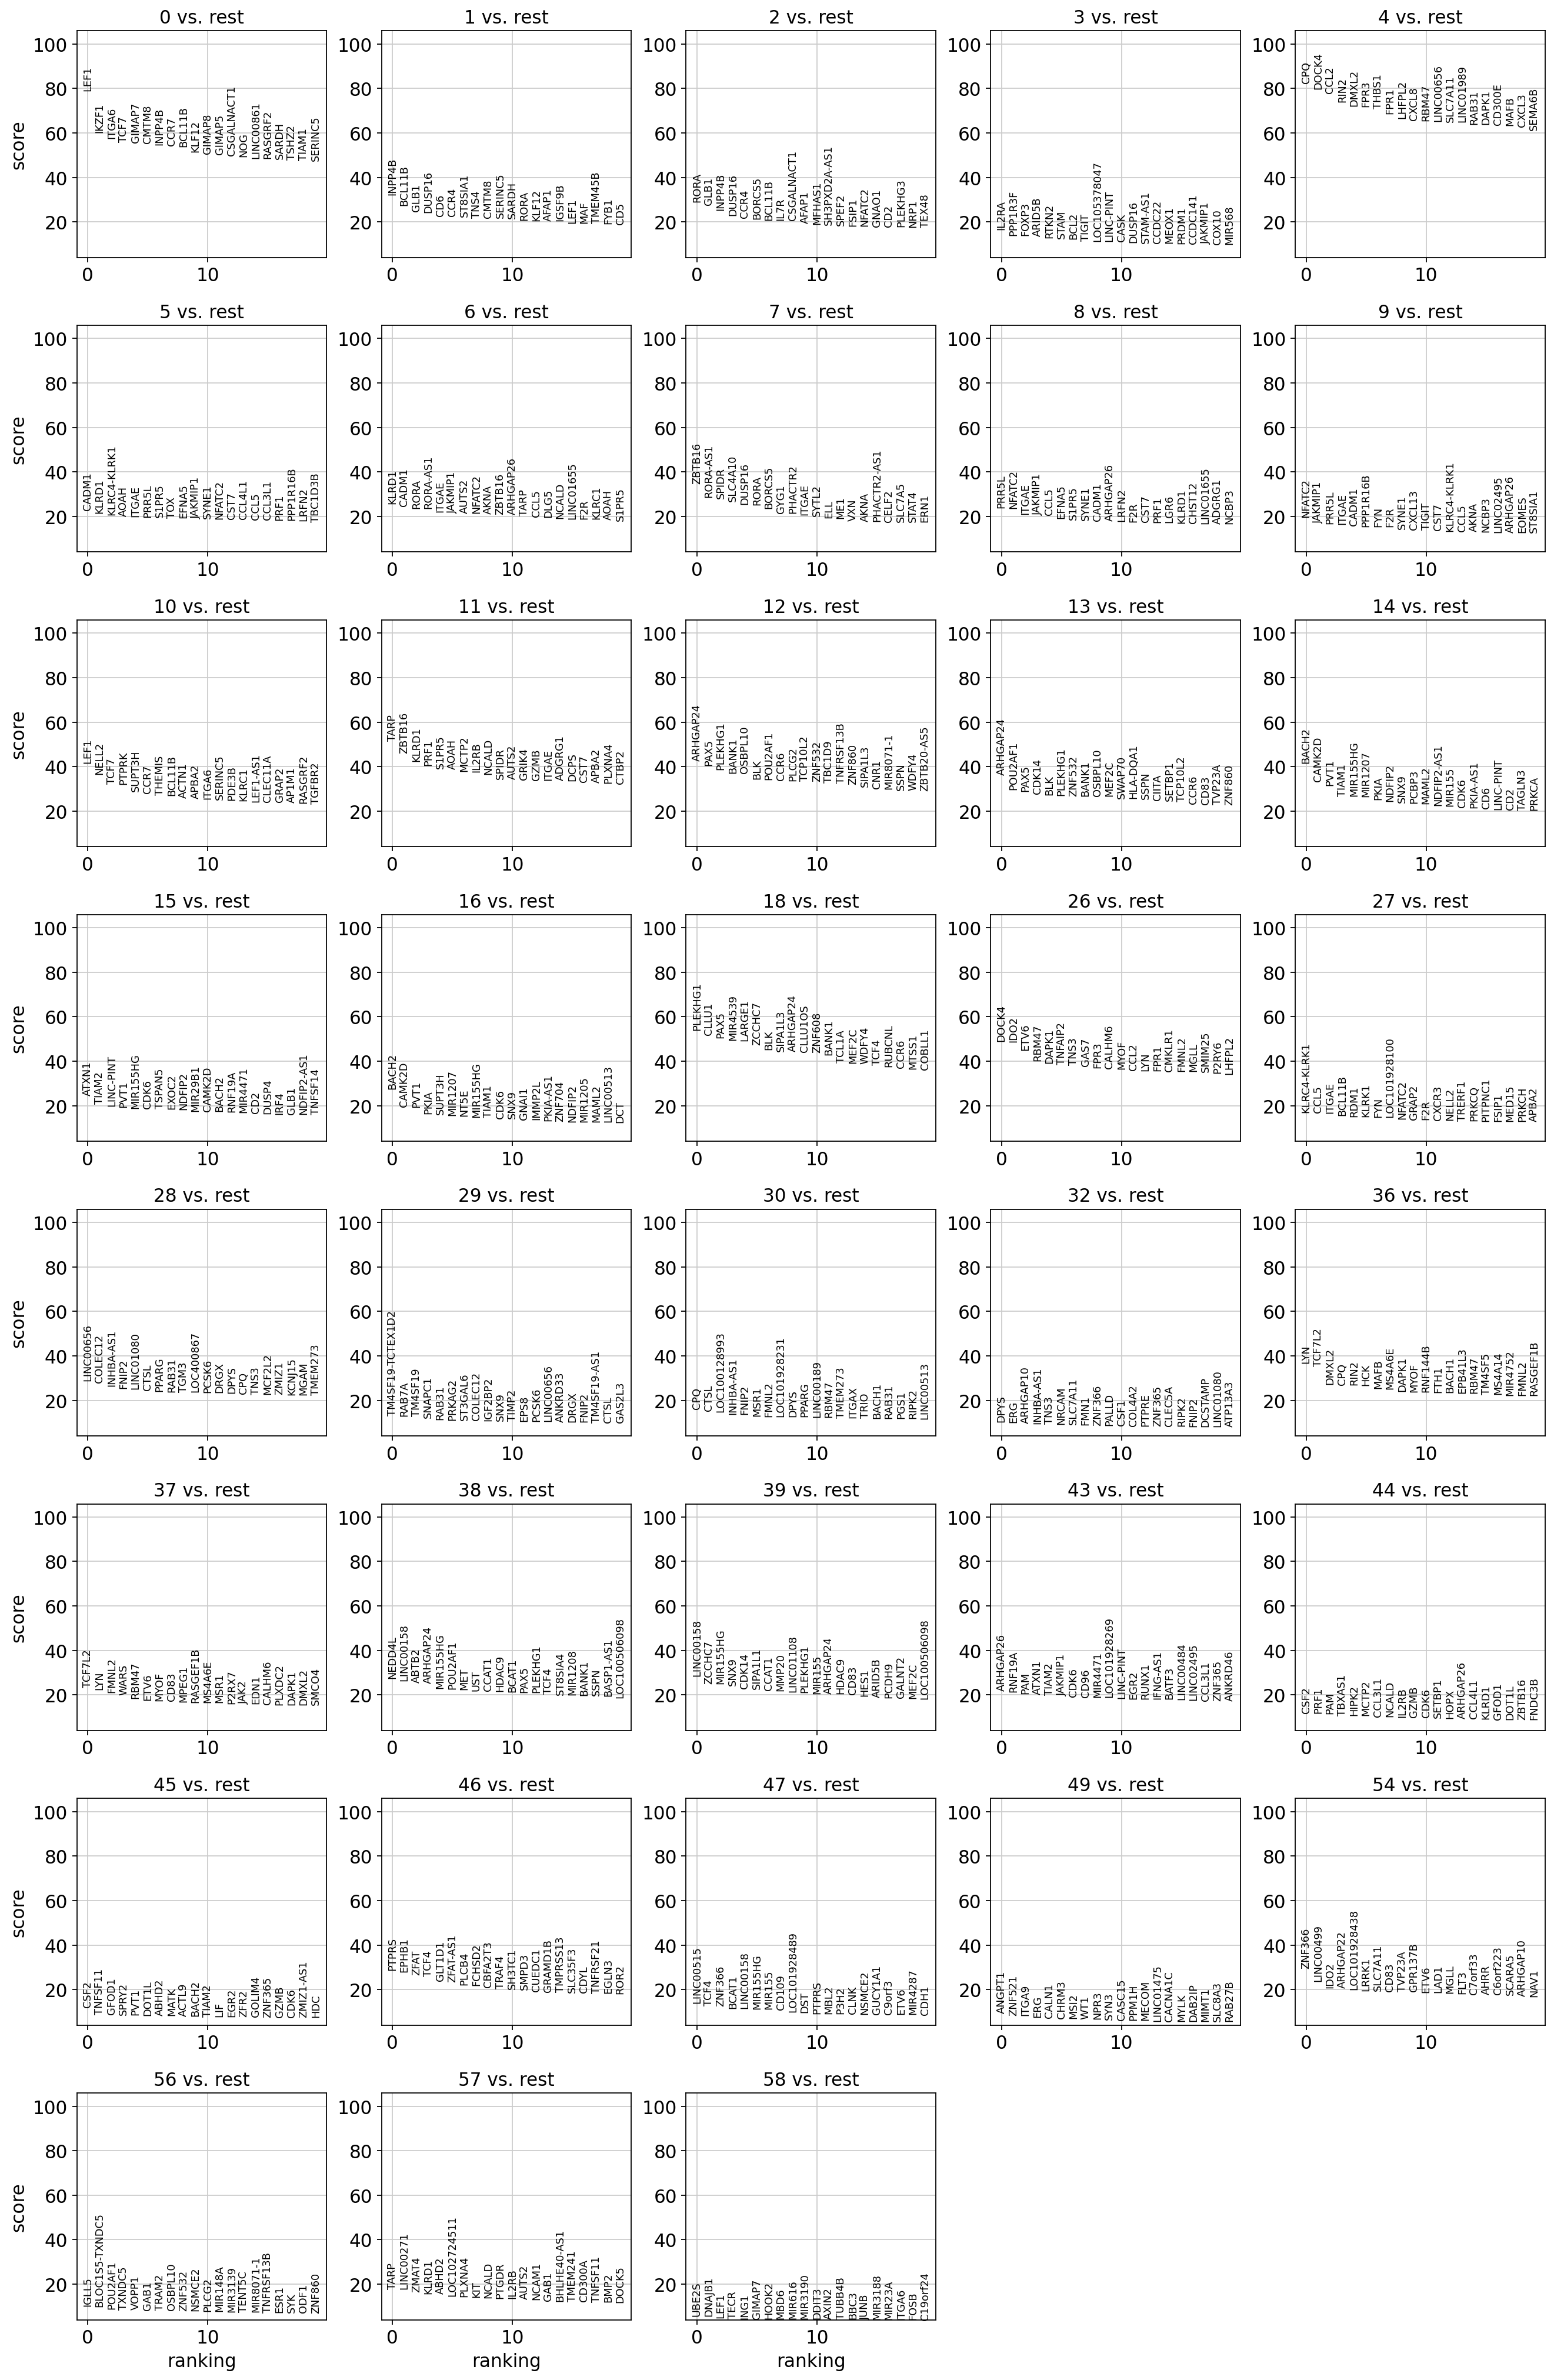

In [101]:
sc.settings.verbosity = 0 
warnings.filterwarnings('ignore')
sc.tl.rank_genes_groups(concat_raw, groupby='leiden', n_genes=20)
warnings.filterwarnings('default')
sc.pl.rank_genes_groups(concat_raw, ncols=5, n_genes=20)
sc.settings.verbosity = 4

In [73]:
concat_raw.uns['cond_colors'] = [cond_colors[i] for i in concat_raw.obs['cond'].cat.categories]

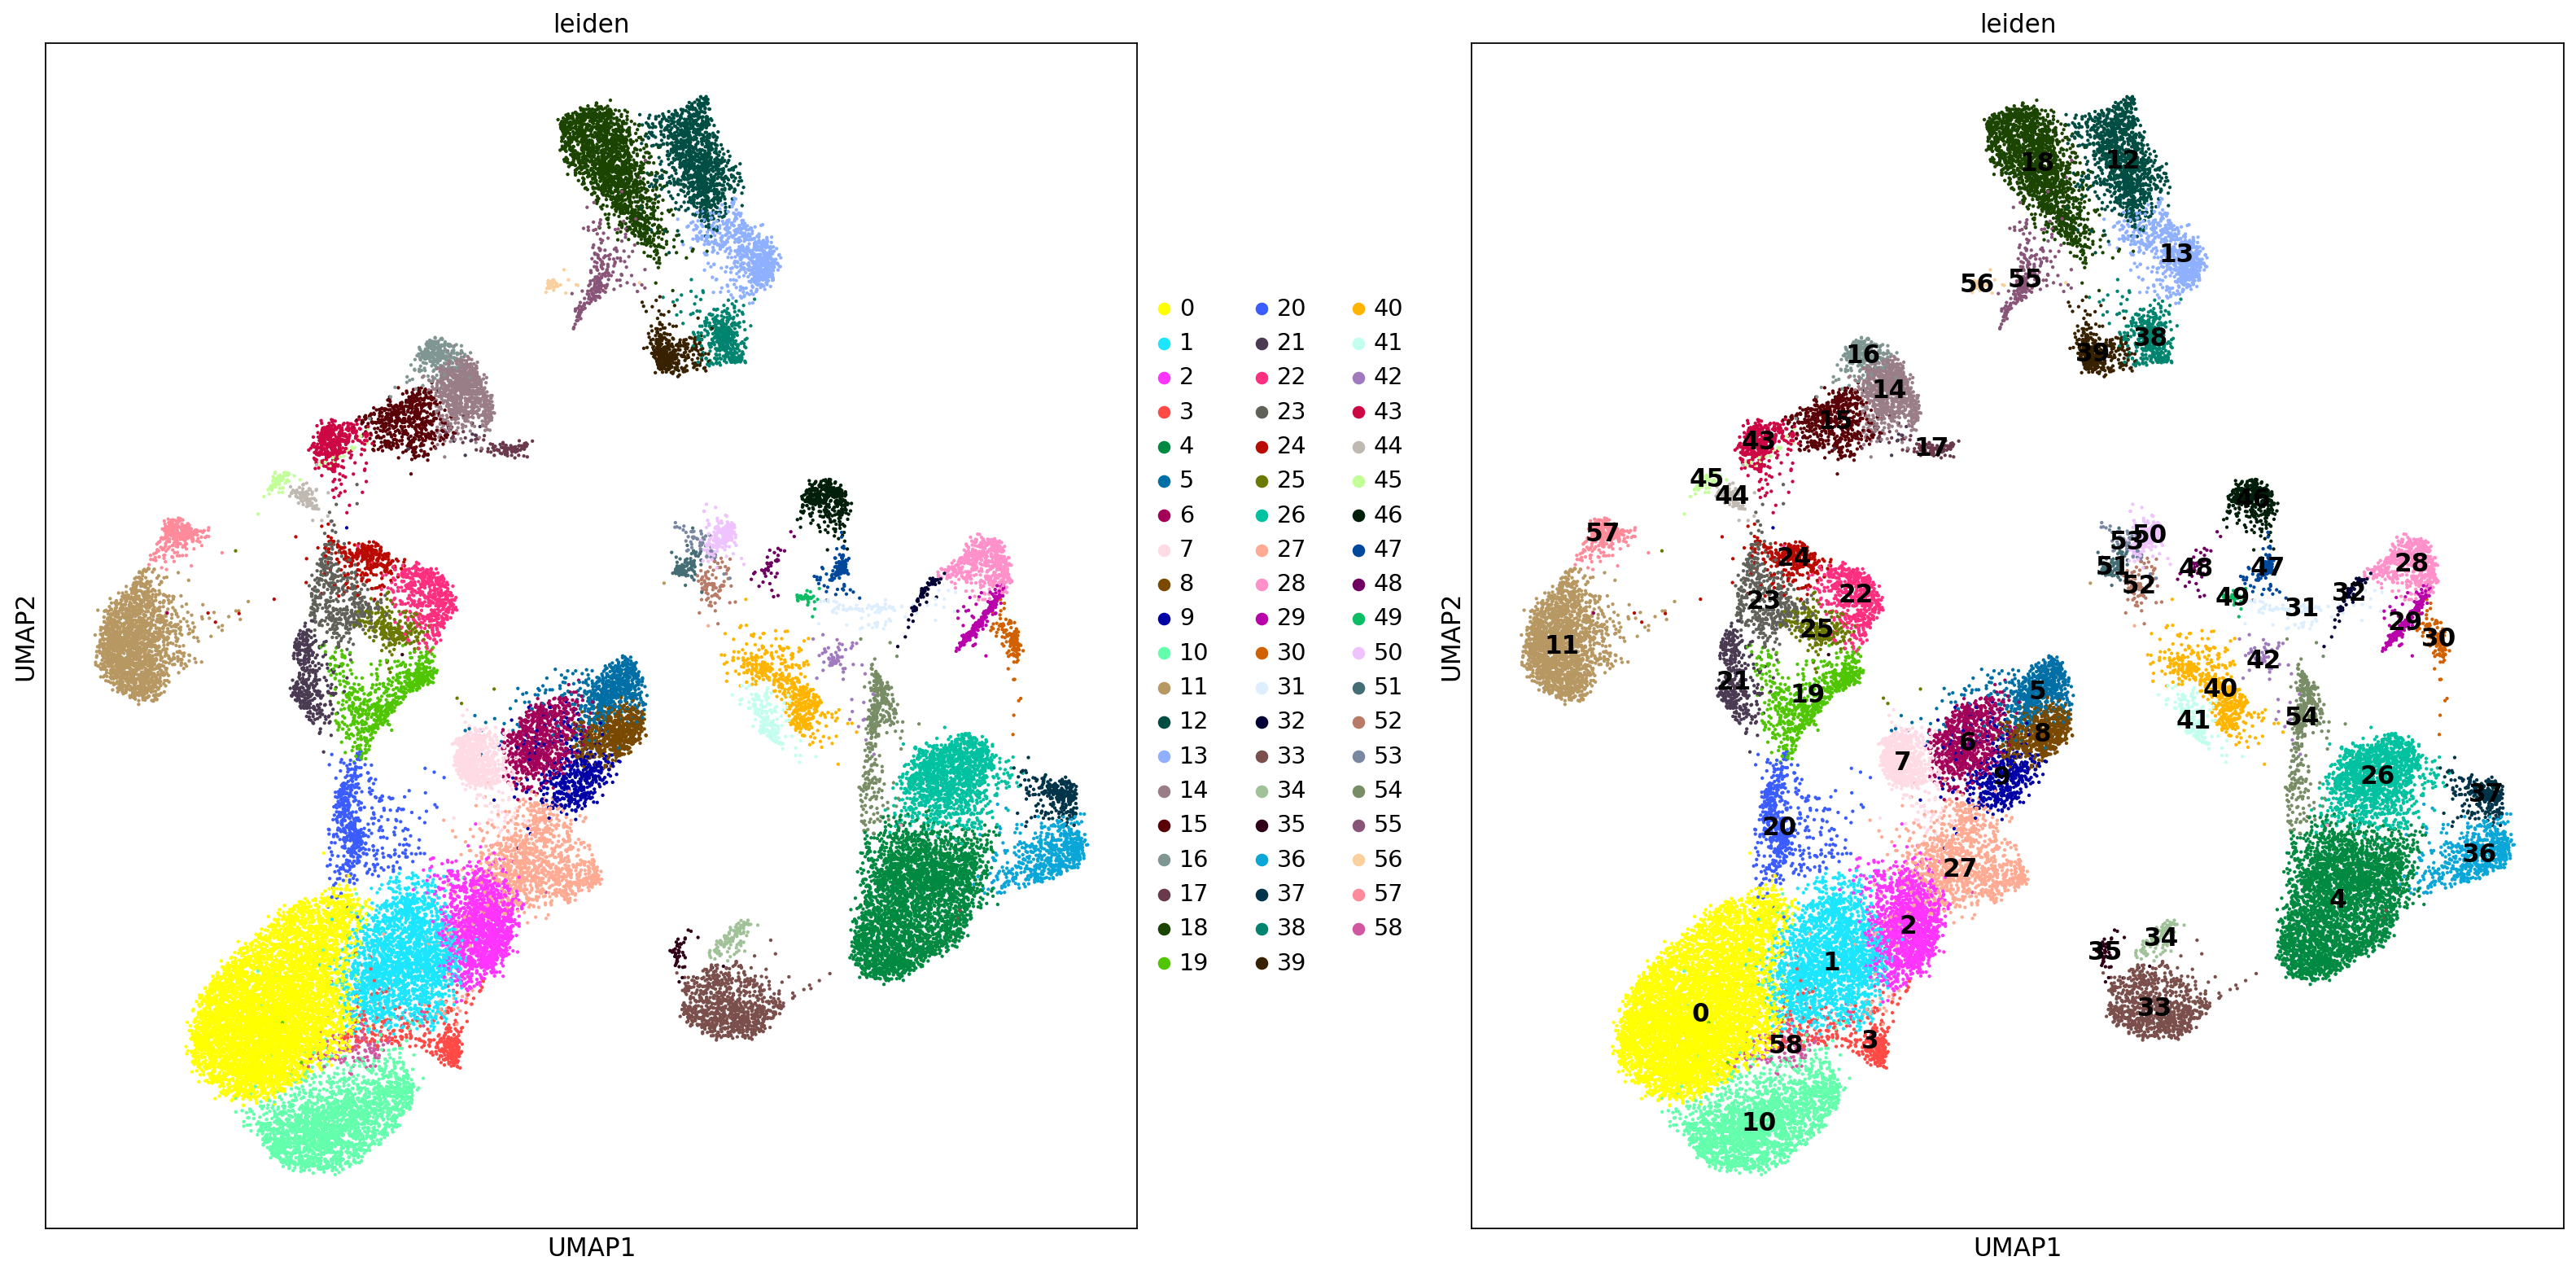

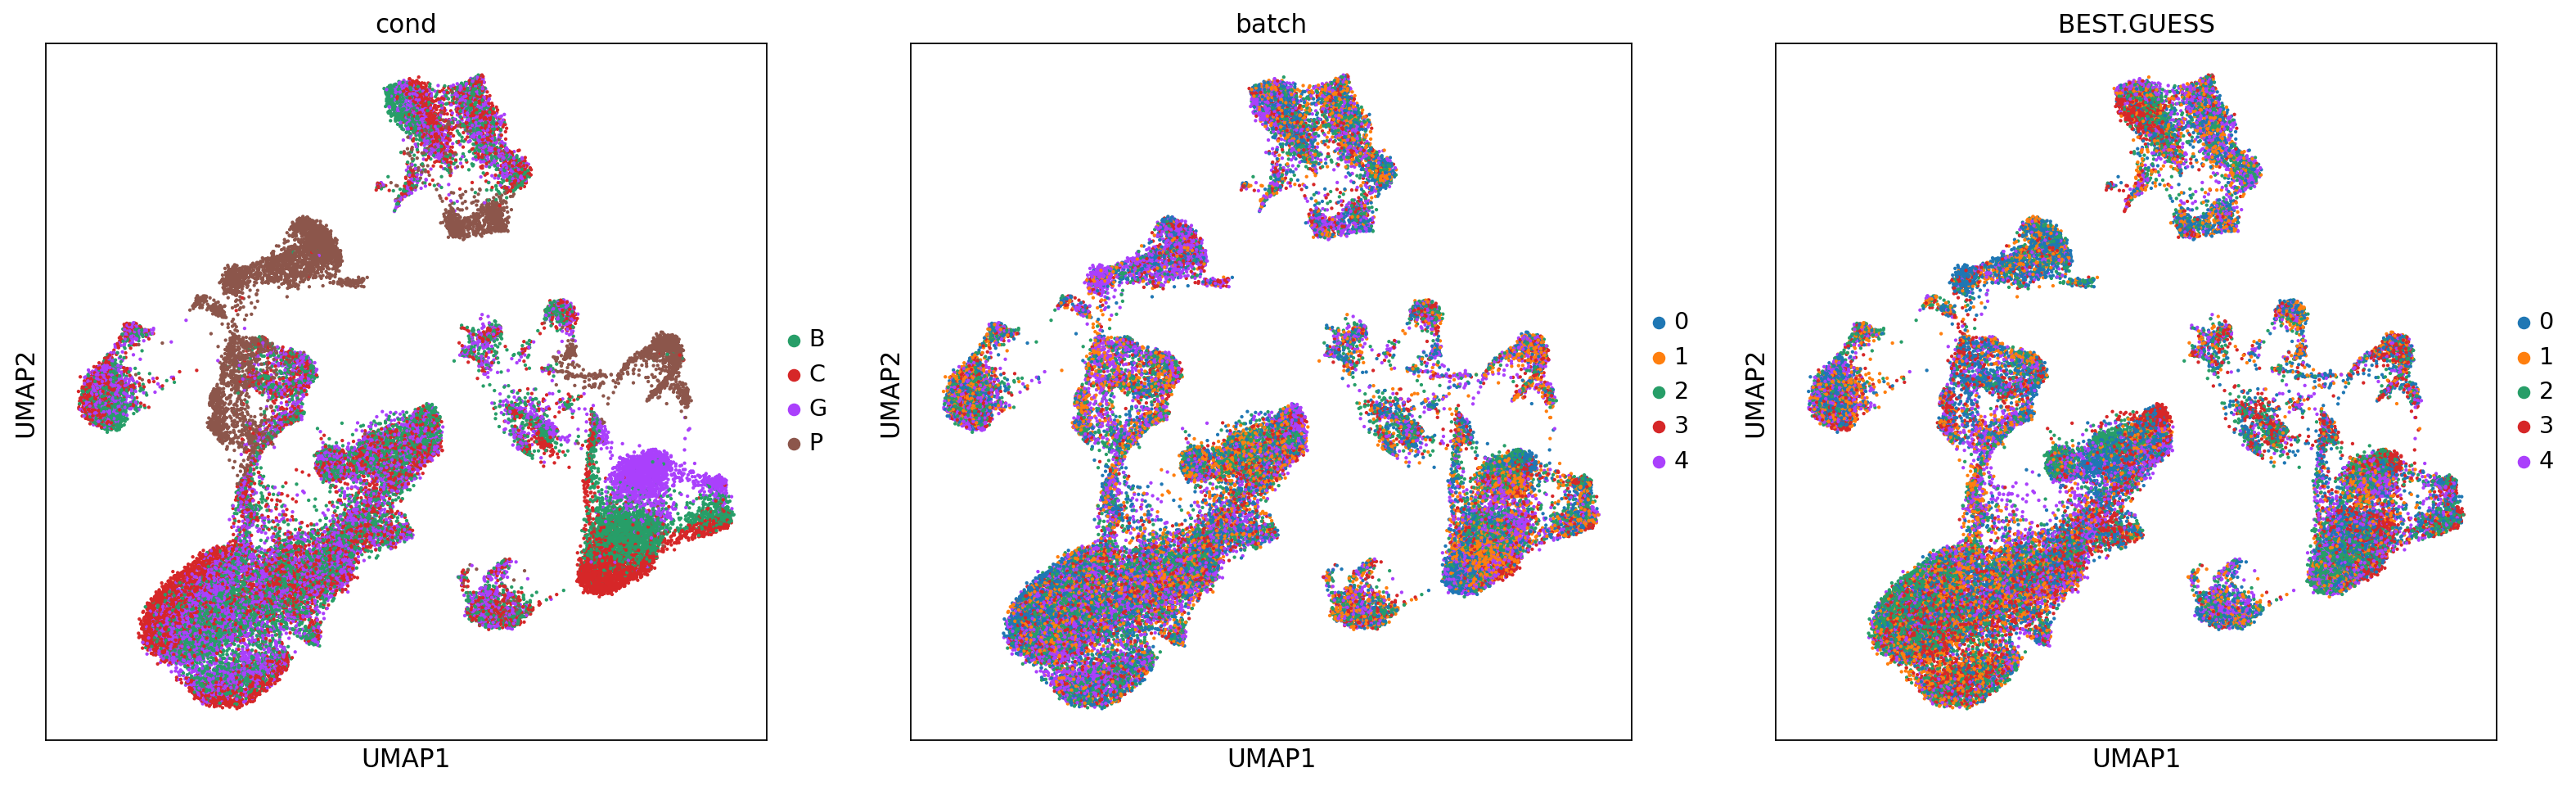

In [38]:
fig, ax = plt.subplots(1,2,figsize=(20,10))
sc.pl.umap(concat_raw, color=['leiden'], ax=ax[0], size=15, return_fig=False, show=False)
sc.pl.umap(concat_raw, color=['leiden'], ax=ax[1], legend_loc='on data', size=15, return_fig=False, show=False)
plt.tight_layout()
plt.show()
fig, ax = plt.subplots(1,3,figsize=(24,7))
for i, cov in enumerate(['cond', 'batch', 'BEST.GUESS']):
    sc.pl.umap(concat_raw, color=cov, ax=ax[i], size=15, return_fig=False, show=False);
plt.show()

In [97]:
ct2_mapper = {'0': 'T4_Naive',
              '1': 'T4_Mem',
              '2': 'T4_Mem',
              '3': 'T4_Mem',
              '4': 'cM',
              '5': 'T_Tox',
              '6': 'T_Tox',
              '7': 'T_Tox',
              '8': 'T_Tox',
              '9': 'T_Tox',
              '10': 'T8_Naive',
              '11': 'NK',
              '12': 'B_Mem',
              '13': 'B_Mem',
              '14': 'T4_Naive',
              '15': 'T4_Mem',
              '16': 'T8_Naive',
              '17': 'contam/doublet',
              '18': 'B_Naive',
              '19': 'mito/stress',
              '20': 'mito/stress',
              '21': 'mito/stress',
              '22': 'mito/stress',
              '23': 'mito/stress',
              '24': 'mito/stress',
              '25': 'mito/stress',
              '26': 'cM',
              '27': 'T4_Mem',
              '28': 'cM',
              '29': 'cDC',
              '30': 'ncM',
              '31': 'contam/doublet',
              '32': 'cM',
              '33': 'mito/stress',
              '34': 'mito/stress',
              '35': 'mito/stress',
              '36': 'ncM',
              '37': 'ncM',
              '38': 'B_Mem',
              '39': 'B_Naive',
              '40': 'contam/doublet',
              '41': 'contam/doublet',
              '42': 'contam/doublet',
              '43': 'T_Tox',
              '44': 'NK',
              '45': 'NK',
              '46': 'pDC',
              '47': 'pDC',
              '48': 'contam/doublet',
              '49': 'HSC',
              '50': 'contam/doublet',
              '51': 'contam/doublet',
              '52': 'contam/doublet',
              '53': 'contam/doublet',
              '54': 'cDC',
              '55': 'mito/stress',
              '56': 'PB',
              '57': 'NK'
             }
# T4_Naive: expression of CD4, INPP4B and BACH2 10.1073/pnas.1306691110
# T8_Naive: expression of KLRC genes (mRNA data) and BACH2 10.1073/pnas.1306691110
# T4_Mem: expression of TIGIT (mRNA data), ITGAE+ subset (ADT data) and Tregs (IL2RA+, mRNA + ADT data), cluster 24 microRNAs (10.1084/jem.20150990)
# T_Tox: expression of PRR5L (mRNA data, linked to NK cytoxicity 10.3389/fcell.2020.566090, 10.1038/ncb2507, 10.1038/nature08155)
# After looking at RBFOX1 and CD69 expression, I've realized the random clusters that I couldn't place from just looking at the UMAP are actually probably "mito" clusters
# Obviously hard to tell these are mito clusters because we don't capture mitochondrial RNA but with these two genes it seems likely
# Also there's this: https://pubmed.ncbi.nlm.nih.gov/29358748/
# NK_CD16: expressin of S1PR5
# Cluster 56 expressing B/Myeloid cell expression marker ARHGAP24, likely contamination or doublet
# Cluster 33 expressing TIAM1 and RGS6, which according to 10.1136/gutjnl-2017-314544 are tumor suppressors, and TIAM1 has been implicated in apoptosis, but nothing definitive so going to keep it as part of cM
# ncM: expression of TCF7L2 (mRNA data)
# Cluster 32 expressing canonical lymphocyte markers, thinking contam/doublet
# cDC: using mRNA genes score, cDC clusters light up. for PMA/I, was debating between cluster 30 and 33, but 30 on UMAP looks more like cDC and is expressing RAB7A (10.3389/fimmu.2017.00340) but not super convincing
# Cluster 39 is contam/doublet based on shared expression of BLK & PAX5 (B cell specific) and DAPK1 & FPR3 (myeloid specific)
# pDC: using mRNA genes score, pDCs are high expressing
# HSC: expression of ERG and ITGA9 (mRNA data), and high mRNA genes score for HSC. I would reckon the small cluster in bottom left of PMA/I PDCs is *also* HSC but too small to cluster out
# B_Mem: slightly higher mRNA genes score for B_Mem, as well as expression of CD70 (10.1016/j.coi.2005.04.004)
# B_Naive: slightly higher mRNA genes score for B_Mem, as well as expression of TCL1A (highly specific in mRNA to Naive B cells and pDCs, recapitulated in ATAC data)

In [74]:
ct3_mapper_diff = {
    '11': 'NK_CD16+',  
    '12': 'B_Mem_TPV23A-', 
    '27': 'T4_Mem_ITGAE', 
    '57': 'NK_CD56+', 
    '3': 'Treg', 
    '44': 'NK_CD16+',  
    '45': 'NK_CD56+', 
    '13': 'B_Mem_TPV23A+'
}

In [76]:
ct3_mapper = ct2_mapper.copy()
for ct in ct3_mapper_diff:
    ct3_mapper[ct] = ct3_mapper_diff[ct]

In [77]:
concat_raw.obs['ct2'] = concat_raw.obs['leiden'].map(ct2_mapper)
concat_raw.obs['ct3'] = concat_raw.obs['leiden'].map(ct3_mapper)

In [78]:
concat_raw = concat_raw[~concat_raw.obs['ct2'].isin(['contam/doublet', 'mito/stress'])].copy()

In [81]:
ct1_mapper = {
    'cM': 'myeloid_cells',
    'T4_Naive': 'T4_Naive',
    'T4_Mem': 'T4_Mem',
    'B_Mem': 'B_cells',
    'cDC': 'myeloid_cells',
    'ncM': 'myeloid_cells',
    'NK': 'NK_T_Tox',
    'B_Naive': 'B_cells',
    'T8_Naive': 'T8_Naive',
    'pDC': 'myeloid_cells',
    'T_Tox': 'NK_T_Tox',
    'HSC': 'HSC',
    'PB': 'PB'
}

In [82]:
concat_raw.obs['ct1'] = concat_raw.obs['ct2'].map(ct1_mapper)

... storing 'ct2' as categorical
... storing 'ct3' as categorical
... storing 'ct1' as categorical


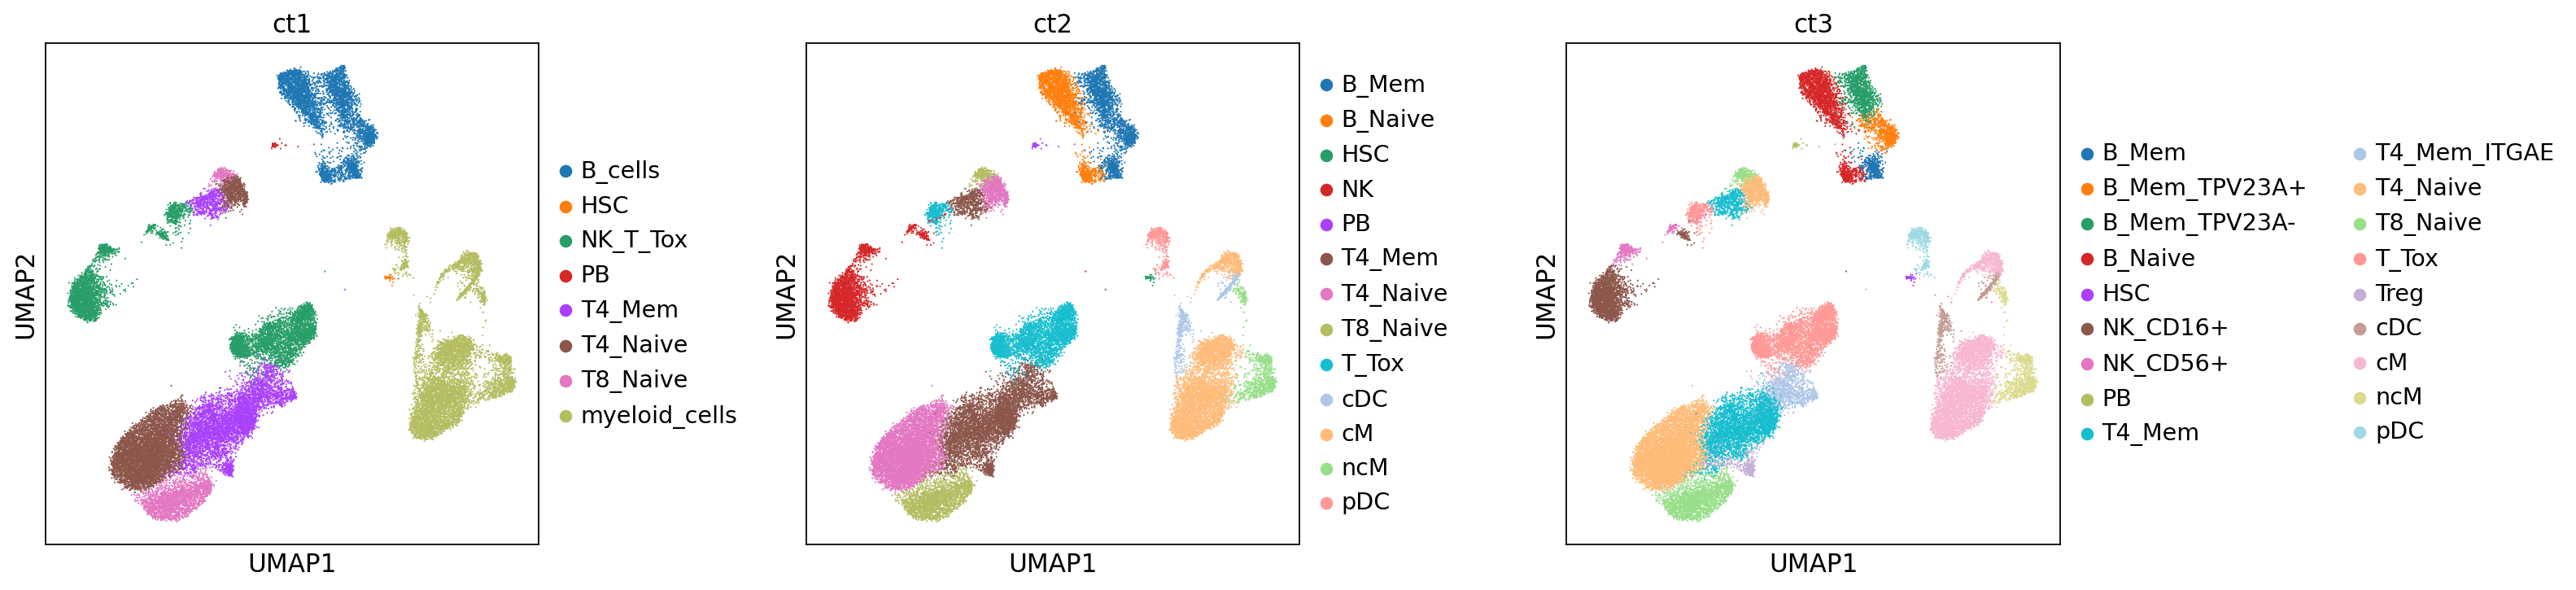

In [83]:
fig, axes = plt.subplots(1,3, figsize=(20,4.75))
for ct_type, ax in zip(['ct1', 'ct2', 'ct3'], np.ravel(axes)):
    sc.pl.umap(concat_raw, color=[ct_type], ax=ax, return_fig=False, show=False);
plt.tight_layout()

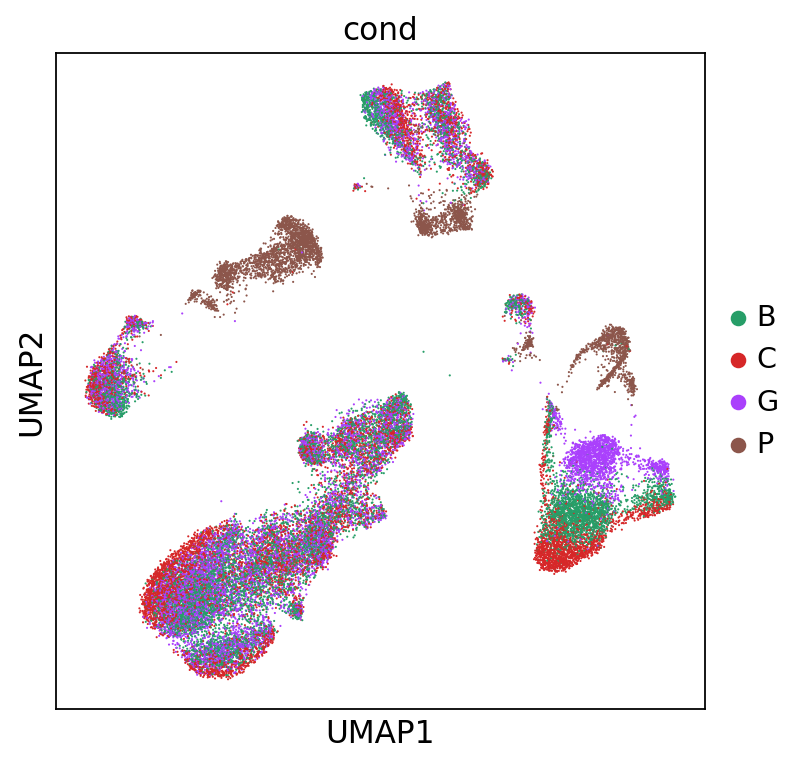

In [84]:
fig, axes = plt.subplots(1,1, figsize=(5.25,5))
for ct_type, ax in zip(['cond'], np.ravel(axes)):
    sc.pl.umap(concat_raw, color=[ct_type], ax=ax, return_fig=False, show=False);
plt.tight_layout()

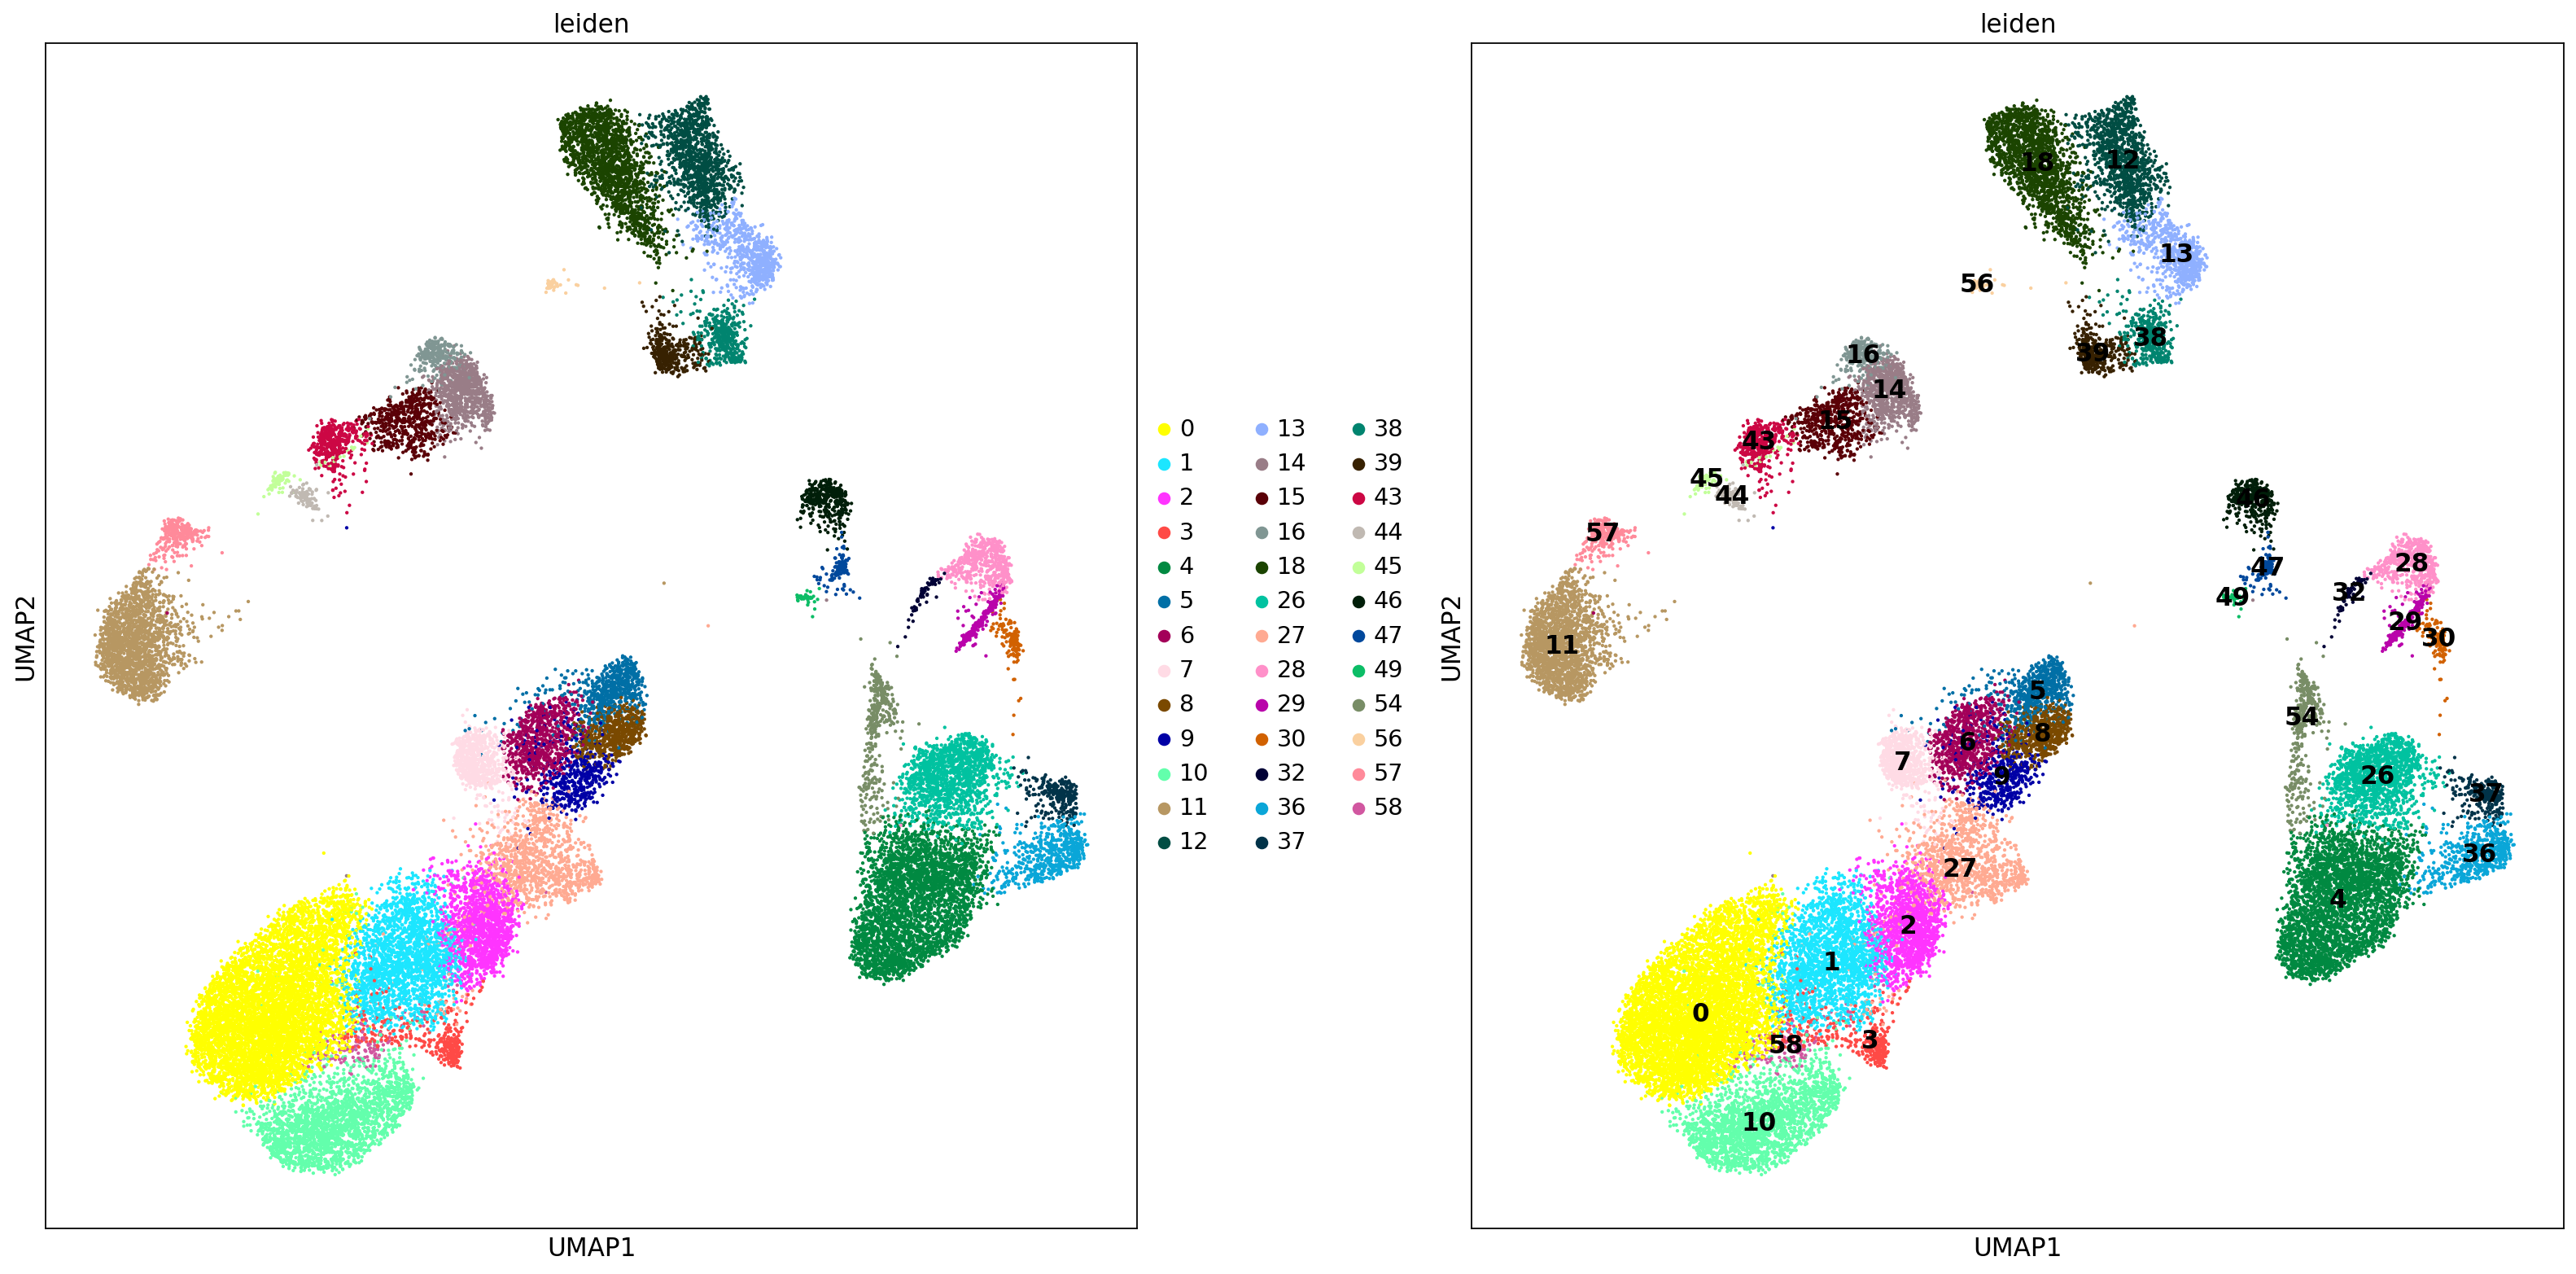

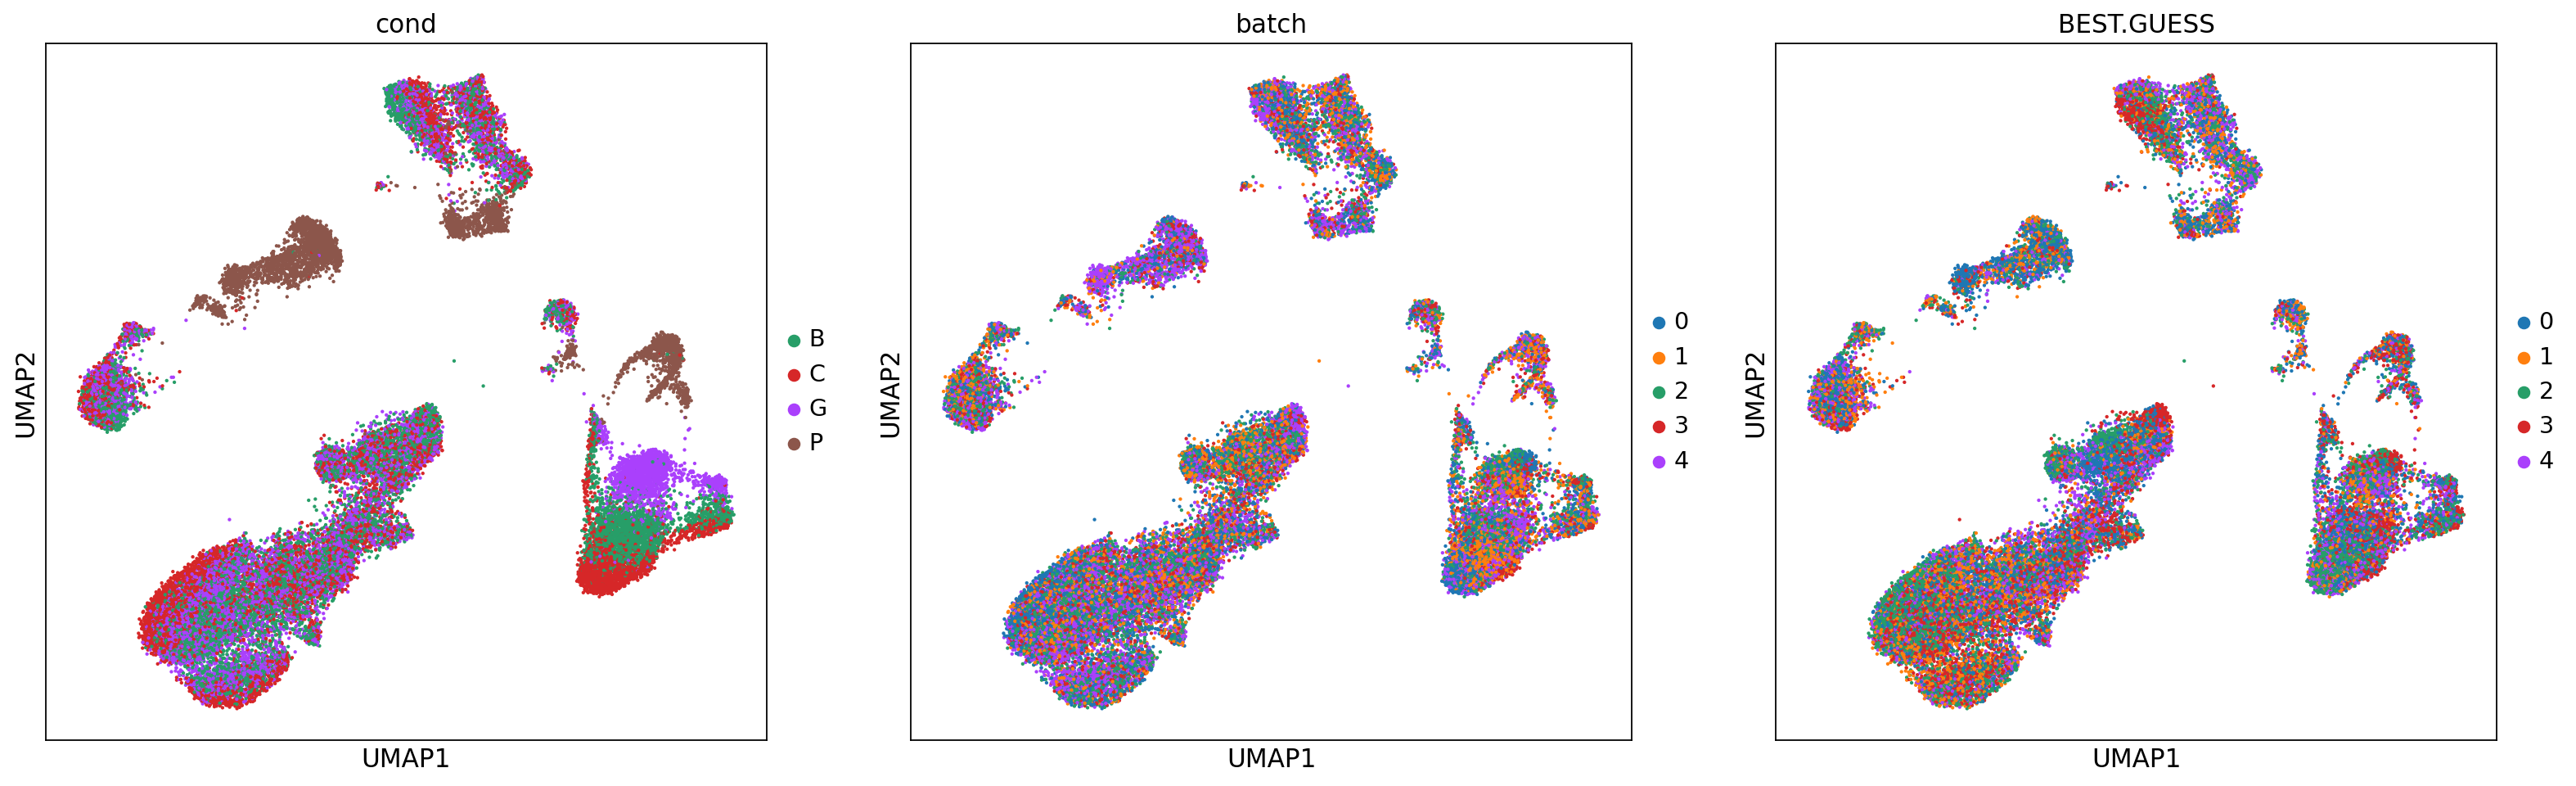

In [85]:
fig, ax = plt.subplots(1,2,figsize=(20,10))
sc.pl.umap(concat_raw, color=['leiden'], ax=ax[0], size=15, return_fig=False, show=False)
sc.pl.umap(concat_raw, color=['leiden'], ax=ax[1], legend_loc='on data', size=15, return_fig=False, show=False)
plt.tight_layout()
plt.show()
fig, ax = plt.subplots(1,3,figsize=(24,7))
for i, cov in enumerate(['cond', 'batch', 'BEST.GUESS']):
    if cov == 'COND':
        sc.pl.umap(concat_raw, color=cov, ax=ax[i], size=15, return_fig=False, show=False, palette=sc.pl.palettes.default_20[2:6]);
    else:
        sc.pl.umap(concat_raw, color=cov, ax=ax[i], size=15, return_fig=False, show=False)
plt.show()

In [87]:
path = prefix_atac + 'h5ads/concat_4.h5ad'

# concat_raw.write_h5ad(path)
concat_raw = sc.read_h5ad(path) 